In [22]:
%pylab inline
import tensorflow as tf
import numpy as np
import DifferentiableHOS as DHOS
import flowpm
import flowpm.tfpower as tfpower
import flowpm.scipy.interpolate as interpolate
import flowpm.raytracing as raytracing
from flowpm.tfpower import linear_matter_power
import astropy.units as u
import tensorflow_addons as tfa
import flowpm.constants as constants
from itertools import cycle
import jax
import jax_cosmo as jc
from DifferentiableHOS.pk import pk as pkl
import jax_cosmo.power as power
from jax_cosmo.power import linear_matter_power as lmp

Populating the interactive namespace from numpy and matplotlib


/usr/common/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['power']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [23]:
n_lens = 44       # Number of lensplanes in the lightcone
box_size=50.     # Transverse comoving size of the simulation volume
nc = 128           # Number of transverse voxels in the simulation volume
field_size = 5.   # Size of the lensing field in degrees
field_npix = 512  # Number of pixels in the lensing field
batch_size = 1    # Number of simulations to run in parallel
Omega_c=0.2589
sigma8=0.8159

In [24]:
r = tf.linspace(0.,box_size * n_lens, n_lens+1)
r_center = 0.5 * (r[1:] + r[:-1])

In [25]:
#@tf.function
def compute_kappa(Omega_c, sigma8):
  """ Computes a convergence map using ray-tracing through an N-body for a given
    set of cosmological parameters
    """
  # Instantiates a cosmology with desired parameters
  cosmology = flowpm.cosmology.Planck15(Omega_c=Omega_c, sigma8=sigma8)

  # Schedule the center of the lensplanes we want for ray tracing
  r = tf.linspace(0.,box_size * n_lens, n_lens+1)
  r_center = 0.5 * (r[1:] + r[:-1])

  # Retrieve the scale factor corresponding to these distances
  a = flowpm.tfbackground.a_of_chi(cosmology, r)
  a_center = flowpm.tfbackground.a_of_chi(cosmology, r_center)

  # We run 4 steps from initial scale factor to start of raytracing
  init_stages = tf.linspace(0.1, a[-1], 4)
  # Then one step per lens plane
  stages = tf.concat([init_stages, a_center[::-1]], axis=0)

  # Create some initial conditions
  k = tf.constant(np.logspace(-4, 2, 512), dtype=tf.float32)
  pk = linear_matter_power(cosmology, k)
  pk_fun = lambda x: tf.cast(tf.reshape(interpolate.interp_tf(tf.reshape(tf.cast(x, tf.float32), [-1]), k, pk), x.shape), tf.complex64)
  initial_conditions = flowpm.linear_field(
          [nc, nc, nc],
          [box_size, box_size, box_size],
          pk_fun,
          batch_size=1)
  #initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)
  lin_states=[] 
  for i in range(len(stages)):
      initial_conditions = flowpm.linear_field(
          [nc, nc, nc],
          [box_size, box_size, box_size],
          pk_fun,
          batch_size=1)
      lin_states.append(flowpm.lpt_init(cosmology,      #lin_states order from 0.1 to 0.9825
                        initial_conditions,
                        0.5229969, order=1))            #stages order from 0.1 to 0.9825
      print(i, stages[i])
  # Extract the lensplanes
  lensplanes = []
  matrix = flowpm.raytracing.rotation_matrices()
  for i, j in zip(range(len(a_center)), cycle(range(6))):
    print(r_center[i], a_center[i], 1/a_center[i] -1)
    plane = flowpm.raytracing.density_plane(
        lin_states[::-1][i],
        [nc, nc, nc],
        nc // 2,
        width=nc,
        plane_resolution=512,
        rotation=matrix[j],
        shift=flowpm.raytracing.random_2d_shift(),
    )

    plane = tf.expand_dims(plane, axis=-1)

    lensplanes.append((r_center[i], a_center[i], plane[..., 0]))
  xgrid, ygrid = np.meshgrid(
      np.linspace(0, field_size, field_npix,
                  endpoint=False),  # range of X coordinates
      np.linspace(0, field_size, field_npix,
                  endpoint=False))  # range of Y coordinates

  coords = np.stack([xgrid, ygrid], axis=0) 
  c = coords.reshape([2, -1]).T / 180.*np.pi # convert to rad from deg
  # Create array of source redshifts
  z_source = tf.constant([0.92])
  m = flowpm.raytracing.convergenceBorn(cosmology,
                                        lensplanes,
                                        dx=box_size / 512,
                                        dz=box_size,
                                        coords=c,
                                        z_source=z_source)

  m = tf.reshape(m, [1, field_npix, field_npix, -1])

  return m, lensplanes, r_center, a_center, lin_states, initial_conditions

In [33]:
km=[]
for i in range(20):
    m, lensplanes, r_center, a_center, states, initial_conditions=compute_kappa(Omega_c, sigma8)
    km.append(m)

0 tf.Tensor(0.1, shape=(), dtype=float32)
1 tf.Tensor(0.23846918, shape=(), dtype=float32)
2 tf.Tensor(0.37693834, shape=(), dtype=float32)
3 tf.Tensor(0.5154075, shape=(), dtype=float32)
4 tf.Tensor(0.5192021, shape=(), dtype=float32)
5 tf.Tensor(0.52679145, shape=(), dtype=float32)
6 tf.Tensor(0.53467464, shape=(), dtype=float32)
7 tf.Tensor(0.54244375, shape=(), dtype=float32)
8 tf.Tensor(0.55055094, shape=(), dtype=float32)
9 tf.Tensor(0.55869555, shape=(), dtype=float32)
10 tf.Tensor(0.5668523, shape=(), dtype=float32)
11 tf.Tensor(0.5752359, shape=(), dtype=float32)
12 tf.Tensor(0.58360183, shape=(), dtype=float32)
13 tf.Tensor(0.5922384, shape=(), dtype=float32)
14 tf.Tensor(0.6008251, shape=(), dtype=float32)
15 tf.Tensor(0.6097294, shape=(), dtype=float32)
16 tf.Tensor(0.61854863, shape=(), dtype=float32)
17 tf.Tensor(0.62773746, shape=(), dtype=float32)
18 tf.Tensor(0.6368023, shape=(), dtype=float32)
19 tf.Tensor(0.6462941, shape=(), dtype=float32)
20 tf.Tensor(0.65561855, s

In [35]:
ps_arr=[]
for i in range (20):
    ell, power_spectrum = DHOS.statistics.power_spectrum(km[i][0,...,0], field_size, field_npix)
    ps_arr.append(power_spectrum )

In [36]:
ps=tf.reduce_mean(ps_arr,axis=0)

In [37]:
cosmo=jc.Planck15()
nz =jc.redshift.delta_nz(0.92)
probes = [jc.probes.WeakLensing([nz])] 
cls = jc.angular_cl.angular_cl(cosmo, ell.numpy(), probes,nonlinear_fn=power.linear)

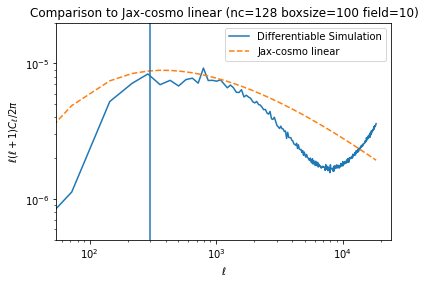

In [38]:
l=ell
loglog(l, l*(l+1)*ps/(2*pi),label='Differentiable Simulation')
loglog(l, l*(l+1)*cls[0]/(2*pi), '--',label='Jax-cosmo linear')
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
#xlim(1,1e3)
axvline(300)
xlabel('$\ell$')
title('Comparison to Jax-cosmo linear (nc=128 boxsize=100 field=10)')
ylim(5e-7, 2e-5)
legend()


In [39]:
pk_array=[]
pk_jax=[]
for i in range(len(a_center)):
    final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), states[::-1][i][0])
    final_field=tf.reshape(final_field, [nc, nc, nc])

    k, power_spectrum = pkl(final_field,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                            box_size]),kmin=0.1,dk=2*np.pi/box_size)
    pk_array.append(power_spectrum)
    pk_jax.append(lmp(cosmo, k, a=0.5229969))

/global/homes/d/dlan/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5293: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


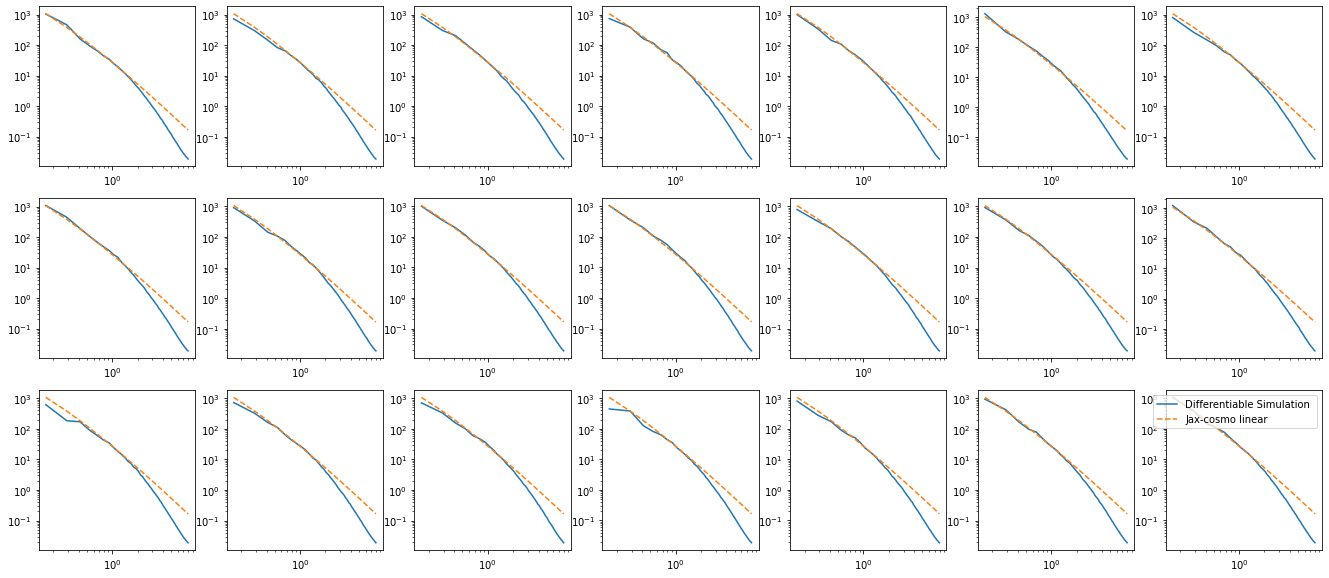

In [40]:
fig, axs = plt.subplots(nrows=3, ncols=7, figsize=(23, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, p in zip(axs.flat, pk_array):
    ax.loglog(k, p,label='Differentiable Simulation ')
for ax, pj in zip(axs.flat, pk_jax):
    ax.loglog(k, pj,'--',label='Jax-cosmo linear')
    legend()
plt.show()
#savefig('snap.png',dpi=200)

In [41]:
pickle.dump(
      {
          'ps': ps.numpy(),
          'ell': ell.numpy(),
      }, open('result_field5_bs50_512leres', "wb"))

In [18]:
import pickle